In [ ]:
import math # for basic functions such as sqrt 
import matplotlib.pyplot as plt # for plotting functions
import numpy as np # for algebra, arrays, etc 
from scipy import interpolate # for interpolation function
from scipy.stats import norm # for the Q-function 
import time # for time.sleep(seconds) in debugging 
from plotly.subplots import make_subplots # for interactive graphics.
import plotly.graph_objects as go # ídem 
try:
  from google.colab import output # Play an audio beep. Added to know when an execution starts and ends.
except:
  pass # When libraries are loaded in others platforms than Colab, such as ipython, this pass avoids the loading error

def _global_fun(alphabet = {'00':-1-1j, '01':-1+1j, '10':1-1j, '11':1+1j}, freq_shift = 0.00, n = 25, phase_shift = 0.00, \
                samplesxsym = 2**6, signal_span = 19, step = 0.001, symbols = 20000, ups_value = 1):
  
  global ALPHABET, COD_LEN, FREQ_SHIFT, INV_MAP, SYMBOLS, MU, N, PHASE_SHIFT, SAMPLESxSYM, \
  SIGNAL_SPAN, STEP, TRAINING_END, UPS_VALUE
  
  ALPHABET = alphabet # For alphabet: 1) values may be different in order to invert ad decoding. 2) leading zeros must be in keys starting with zeros
  COD_LEN = len(str(list(ALPHABET.keys())[0])) # Length of the coding bit chain which maps to a symbol
  #FREQ_SHIFT = freq_shift*samplesxsym # frequency shift at the receiver stage
  FREQ_SHIFT = freq_shift
  INV_MAP = {v: k for k, v in ALPHABET.items()} # To demodulate a values to keys mapping is needed
  SYMBOLS = symbols # iterations quantity
  MU = 0 # initial NCO parameter value for the synchronizer
  N = n # Equalizer coefficient quantity (Lee 3ed, p. 427). It also determines in this code the delay maximum value.
  #PHASE_SHIFT = phase_shift*samplesxsym # phase shift at the receiver stage
  PHASE_SHIFT = phase_shift
  SAMPLESxSYM = samplesxsym # the samples per symbol is the samples+1 quantity between two samples in integer positions, seen in the channel figure 
  SIGNAL_SPAN = signal_span # also known as filter span in symbols, is the total of samples in integer positions, seen in the channel figure
  STEP = step # initial step of the algorithm
  TRAINING_END = SYMBOLS//3
  UPS_VALUE = ups_value # determines communication transmission upsampling
  return None

def ber_ser(vct_h = np.array([1]), asymp = True, EbNodB_MAX = 12, delay = 0, cycle_adjust = True):
# Ref: https://www.mathworks.com/help/comm/ug/awgn-channel.html

  vct_EbNodB = np.arange(EbNodB_MAX)
  vct_ber = np.zeros(EbNodB_MAX)
  vct_ser = np.zeros(EbNodB_MAX)

  sum_values = 0 
  for val in ALPHABET.values():
    sum_values += val*np.conj(val)
  pow_symbol = sum_values.real/len(ALPHABET) # sum_values is already real, the dot real is only for Python integer format

  for it_EbNodB in vct_EbNodB:

    EhNodB = it_EbNodB + round(10*math.log10( COD_LEN )) 
    pow_noise = pow_symbol/(10**(EhNodB/10))   # EhNodB = 10*log10(pow_symbol/pow_noise)
    temp_ber, temp_ser = LMS(vct_h, delay, [], pow_noise, False, cycle_adjust)[0:2]
    vct_ber[it_EbNodB], vct_ser[it_EbNodB] = temp_ber, temp_ser

  plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')

  ax5 = plt.subplot(1,2,1)
  ax5.set_title('Bit Error Rate (BER) vs EbN0')
  ax5.semilogy(vct_ber, 'b*')
  if asymp == True:
      ax5.semilogy(fun_asymp(ALPHABET, EbNodB_MAX)[0], 'r.-') # theoric asymptote
  ax5.grid(True)

  ax6 = plt.subplot(1,2,2)
  ax6.set_title('Symbol Error Rate (SER) vs EbN0')
  ax6.semilogy(vct_ser, 'g*')
  if asymp == True:
      ax6.semilogy(fun_asymp(ALPHABET, EbNodB_MAX)[1], 'r.-') # theoric asymptote
  ax6.grid(True)

def best_delay(vct_h = np.array([1]), pow_noise = 0, show_fig = False):
  delay_max = N
  vct_MSE_delay = np.zeros(delay_max)
  for it_dl in range(0, delay_max): # delay assignment of the delayed loop, gives the index of the present sample Ak
    vct_MSE_delay[it_dl] = LMS(vct_h, it_dl, [], pow_noise, False, False)[2]; 
  best_min = list(vct_MSE_delay).index(min(list(vct_MSE_delay)))
  if show_fig == True:
    plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.semilogy(vct_MSE_delay, 'b-.') 
    plt.grid(True)
    plt.title('Delay vs MSE among transmitted and detected symbols')
  return best_min # the index of the delay value for minimal symbol MSE

def channel_raised_cos(BW = 0.5, rolloff = 0, show_fig = [1,2,3]):
  # Reference: www.eie.polyu.edu.hk/~em/dtss05pdf/00f%20Eye%20pattern%20and%20equalization.pdf
  # BW indicates the bandwidth of the ideal Nyquist pulse (raised cosine with zero roll-off)
  # f1 = (1-rolloff)*W # f1 indicates the point in which the flat spectrum starts to decay, being the roll-off the decayment trend.
  
  if SIGNAL_SPAN % 2 == 0: 
    print('Important: Parameter SIGNAL_SPAN changed to {}. It must be odd.'.format(SIGNAL_SPAN+1))
  t_max = (SIGNAL_SPAN)//2 
  vct_t = np.arange(-t_max, t_max+1/SAMPLESxSYM, 1/SAMPLESxSYM) # t_max+1 to consider also last value with its interpolation
  vct_n = np.zeros(len(vct_t)).T
  for it_t in range(len(vct_t)):
    t = vct_t[it_t] 
    vct_n[it_t] = np.sinc(2*BW*t) * ( np.cos(2*np.pi*rolloff*BW*t) / (1-16*(rolloff**2)*(BW**2)*(t**2)) ) # Time-domain impulse response

  [vct_mag, vct_phase, vct_fft_x_axis] = freq_response(vct_n, vct_t, True, [1, 2, 3])

  return vct_n

def code(COD_LEN = 2, vct_bit_source = np.array([1])):
  # Generate code as bit chain, after generating random bits
  bit_str = '' # bit string initialization 
  for it_mc_sub_1 in range(COD_LEN): # subdivided time 
    bit = np.random.randint(0, 1 + 1)
    bit_str += str(bit)
    vct_bit_source[1:] = vct_bit_source[0:-1]
    vct_bit_source[0] = bit
  return [bit_str, vct_bit_source] # Being x = 0 or 1, default outputs : 'xx'

def convert_ADC(vct_in, down_value, ideal_freq): 
  
  if ideal_freq == True: 
    freq_mismatch = 0 
  else: 
    freq_mismatch = FREQ_SHIFT
  
  vct_y = vct_in # Actually, from 4*Freq_symbol to 2*Freq_symbol        
  vct_x = np.arange(0, len(vct_y))

  vct_out_x = np.array([])
  for iter in np.arange(0, len(vct_y), down_value):
    arg_mismatch = -(iter/UPS_VALUE)*freq_mismatch*down_value + PHASE_SHIFT
    value_out_x = iter + arg_mismatch
    vct_out_x = np.append(vct_out_x, value_out_x)
  
  fun_ADC = interpolate.interp1d(vct_x, vct_y, kind = 'cubic', fill_value = 'extrapolate')
  vct_out_y = fun_ADC(vct_out_x)

  return [vct_out_y, vct_out_x]

def demodulate(Ak_detected = (1+1j)):
# Demodulation of the symbols
  Ak_det_complex = int(Ak_detected.real)+int(Ak_detected.imag)*1j  # for the zero simplification cases
  sk_demod = INV_MAP[Ak_det_complex]
  return sk_demod # default output: '11'

def det_lag(v1 = np.array([3,4,5,6,7,8,9,10,11,12,13,14]), v2 = np.array([1,2,3,4,5,6,7,8,9,10,11,12]), comparison_bits = 6, length = 12, new_delay = 0):
  # With default parameters as given upside, default cycle slip output is -2. Tested with v1 vct_Ak_detected and v2 vct_Ak_delayed.
  # Case when v2 is delayed about v1.
  a = v1[length-comparison_bits : length] 
  for x_cycle in range(0, len(a)):
    e = v2[length-len(a) -x_cycle : length -x_cycle] # yields vector with same length as vector a
    if (a == e).all() == True:
      new_delay += x_cycle
      if new_delay >= SIGNAL_SPAN:
        new_delay -= SIGNAL_SPAN
      return [x_cycle, new_delay] # positive sign
  # Here v1 and v2 are interchanged. Case when v1 is delayed about v2.
  a = v2[length-comparison_bits : length] 
  for x_cycle in range(0, len(a)):
    e = v1[length-len(a) -x_cycle : length -x_cycle]
    if (a == e).all() == True:
      new_delay -= x_cycle
      if new_delay < 0:
        new_delay += SIGNAL_SPAN
      return [-x_cycle, new_delay] # note now the minus sign
  return [0, new_delay] # default case where misadjustment can not be found

def detect(COD_LEN = 2, Yk_equalized = (0.9+0.9j)):
# Detection of the symbols
  Ak_detected = list(ALPHABET.values())[0] # initializes detection with first symbol in alphabet
  det_difference = 10000 # an extremely big difference
  for it_dt in range(len(ALPHABET)): # for the entire alphabet
    it_key = str(bin(it_dt)[2:]) # starting from 2 because binary numbers in python starts with 0b...
    while COD_LEN != len(it_key): # to solve leading zeros problem
      it_key='0'+it_key
    if abs(ALPHABET[it_key] - Yk_equalized) < det_difference : 
      det_difference = abs(ALPHABET[it_key] - Yk_equalized) # distance between equalized and constellation point
      Ak_detected = ALPHABET[it_key] # the detected symbol corresponds to the smaller distance
  return Ak_detected # default output: (1+1j)

def downsample(input_x = np.array([1,2,3,4,5,6,7,8]), x_decim = 2):
  output_x = np.array([input_x[i] for i in range(0,len(input_x), x_decim)]) # take spaced elements of vector using list comprehension
  return output_x # return downsampled output

def eye_diagram(vct_input, eyes):

  rest = len(vct_input) % (UPS_VALUE*(eyes+1))
  real_vector = vct_input.real[0:-(rest+UPS_VALUE*(eyes+1))]
  imag_vector = vct_input.imag[0:-(rest+UPS_VALUE*(eyes+1))]
  real_reshaped = np.reshape(real_vector, [len(real_vector)//(UPS_VALUE*(eyes+1)), UPS_VALUE*(eyes+1)]).T
  imag_reshaped = np.reshape(imag_vector, [len(imag_vector)//(UPS_VALUE*(eyes+1)), UPS_VALUE*(eyes+1)]).T
  real_matrix = np.concatenate((real_reshaped, np.array([np.append(np.array([real_reshaped[0][1:]]), np.NaN)]) ), axis=0)   
  imag_matrix = np.concatenate((imag_reshaped, np.array([np.append(np.array([imag_reshaped[0][1:]]), np.NaN)]) ), axis=0)   
  plt.figure(105, figsize=[2*6.4, 4.8])
  plt.subplot(1,2,1)
  plt.title('Real channel output')
  plt.plot(real_matrix);
  plt.subplot(1,2,2)
  plt.title('Imaginary channel output')
  plt.plot(imag_matrix);
  
def freq_response(vct_n = np.array([1,0,0,0,0]), vct_t = np.array([0]), raised_cos = True, show_fig = [1, 2, 3]):
  
  vct_fft = ( np.fft.fftshift(np.fft.fft(vct_n)/SAMPLESxSYM ) )
  vct_fft_x_axis = np.fft.fftshift( np.fft.fftfreq(len(vct_fft), 1/SAMPLESxSYM ) ) # frequency vector 
  
  vct_mag = np.abs(vct_fft) # magnitude vector
  vct_phase = np.angle(vct_fft) # phase vector 
  for iter in range(len(vct_mag)):
    if vct_mag[iter] < 0.05:
      vct_phase[iter] = 0 # undetermined case for phase
  
  value_marker = 'b.'
  value_line = 'b'
  value_mface= 'r' 
  
  if 1 in show_fig:
    plt.figure(1, ([6, 3])); plt.title('Time Domain'); plt.grid(True);
    if raised_cos == True:
      plt.stem(vct_t, vct_n, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True)
    else:
      plt.stem(vct_n, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True)

  if 2 in show_fig and 3 in show_fig:
    plt.figure(2, ([12, 3]));
    plt.subplot(1,2,1); plt.grid(True); plt.title('Freq Domain. Magnitude'); 
    if raised_cos == True: plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_mag, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True);
    plt.subplot(1,2,2); plt.grid(True); plt.title('Freq Domain. Phase');
    if raised_cos == True: plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_phase, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True);

  elif 2 in show_fig:
    plt.figure(2, ([6, 3])); plt.grid(True); plt.title('Freq Domain. Magnitude'); 
    if raised_cos == True: plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_mag, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True);

  elif 3 in show_fig:
    plt.figure(2, ([6, 3])); plt.grid(True); plt.title('Freq Domain. Phase');
    if raised_cos == True: plt.xlim((-1, 1))
    plt.stem(vct_fft_x_axis, vct_phase, markerfmt = value_marker, linefmt = value_line, basefmt = value_mface, use_line_collection=True);

  return [vct_mag, vct_phase, vct_fft_x_axis]

def fun_asymp(data = True, EbNodB_MAX = 12, show_fig = False):
  # Matched Filter Bound asymptotes.
  # Relation between EhN0 and EbN0. Ref: https://www.mathworks.com/help/comm/ug/awgn-channel.html
  # EhN0[dB] = EbN0[dB] + 10*log10(k), k = bits per symbol (for 4QAM, k=2)
  # To compare with Matlab bertool curves. Ref: https://www.mathworks.com/help/comm/ref/berawgn.html

  # Modulation correction number
  if 'j' not in str(list(ALPHABET.values())):
    correction = 2 # real case modulation
  else:
    correction = 1 # complex case modulation 

  # Calculation of the minimum distance between symbols in the alphabet
  abs_dif_min = 10000 # an extremely big difference
  for val1 in ALPHABET.values():
    for val2 in ALPHABET.values():
      if val1 != val2:
        abs_dif = abs(val1 - val2)
        if abs_dif < abs_dif_min:
          abs_dif_min = abs_dif

  # Calculation of the average number of signals at the minimum distance 
  vct_sym_at_min = np.zeros(len(ALPHABET))
  it = 0
  for val1 in ALPHABET.values():
    for val2 in ALPHABET.values():
      abs_dif = abs(val1 - val2)
      if abs_dif == abs_dif_min:
        vct_sym_at_min[it] += 1
    it += 1
  av_sym_at_min = vct_sym_at_min.sum()/(len(ALPHABET))

  # Matched filter bound
  vct_EbNodB = np.arange(EbNodB_MAX)
  vct_ber_asymp = np.zeros(EbNodB_MAX)
  vct_ser_asymp = np.zeros(EbNodB_MAX)

  a_min = abs_dif_min
  K = av_sym_at_min # K >= 1, the error coefficient, equal to the average number of signals at the minimum distance
  corr = correction

  if show_fig == True:
    print('a_min: {}\nK: {}\ncorr: {}\n'.format(a_min, K, corr))
    plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
    ax3 = plt.subplot(1,2,1)
    ax4 = plt.subplot(1,2,2)

  for it_EbNodB in vct_EbNodB:

    linear_EhNo = 10**( (it_EbNodB + round(10*math.log10( COD_LEN ))) /10)
    sigmaMF_1 = (a_min ** 2) * corr * linear_EhNo # eq. 8.24
    qofx = norm.sf(math.sqrt(sigmaMF_1)/2) # qx = nm.sf(x, loc=0, scale=1) obtains Q-function evaluated at x
    vct_ber_asymp[it_EbNodB] = qofx
    vct_ser_asymp[it_EbNodB] = K * qofx # eq. 8.20
    
    if show_fig == True and data == True:
        ax3.annotate('({}, {})'.format(it_EbNodB, round(vct_ber_asymp[it_EbNodB], 6)),(it_EbNodB, vct_ber_asymp[it_EbNodB]))   # annotate method puts data points in the graphic
        ax4.annotate('({}, {})'.format(it_EbNodB, round(vct_ser_asymp[it_EbNodB], 6)),(it_EbNodB, vct_ser_asymp[it_EbNodB]))   

  if show_fig == True:
    ax3.set_title('Bit Error Rate (BER) vs EbN0');
    ax3.semilogy(vct_EbNodB, vct_ber_asymp, 'b.-')
    ax3.grid(True)
    ax4.set_title('Symbol Error Rate (SER) vs EbN0');
    ax4.semilogy(vct_EbNodB, vct_ser_asymp, 'b.-')
    ax4.grid(True)
  
  return (vct_ber_asymp, vct_ser_asymp)

def interpol(vct_input = np.ones(4, dtype=np.complex_), ti_factor = 1, ti_error = 0.02, down_value = 2, \
            start_point = 0, closed_loop = False, it_k_in = 0): # Gardner interpolator, used in the synchronization loop.
  
  Tsample = 1
  err_clock = ti_error*Tsample
  Ti = ti_factor*Tsample + err_clock
  vct_interp = np.array([], dtype=np.complex_)
  vct_mk_plus_mu = np.array([])
  flag_interpol = 0
  for it_k in np.arange(0, len(vct_input), 1):
    try:
      if closed_loop == True:
        if flag_interpol == 1:
          return [X_kTi, (mk + mu)*down_value + start_point] # Lagrange cubic interpolation output. Vectorial output.
        mk = int(np.floor(it_k_in*Ti/Tsample)) 
        mu = it_k_in*Ti/Tsample - mk
        flag_interpol = 1
      else:
        mk = int(np.floor(it_k*Ti/Tsample)) 
        mu = it_k*Ti/Tsample - mk 
      vct_4rk = np.array([vct_input[(mk-2)*Tsample], vct_input[(mk-1)*Tsample], vct_input[mk*Tsample], vct_input[(mk+1)*Tsample]], dtype=np.complex_)        
      X_kTi = \
      vct_4rk[0]*(-(1/6)*mu**3 + (1/6)*mu) + \
      vct_4rk[1]*((1/2)*mu**3 + (1/2)*mu**2 - mu) + \
      vct_4rk[2]*((-1/2)*mu**3 - mu**2 + (1/2)*mu + 1) + \
      vct_4rk[3]*((1/6)*mu**3 + (1/2)*mu**2 + (1/3)*mu) # Ref: Zhou, 2010, eq. 1. vct_4rk[2] relates to vct_interp[0] (present value)
      vct_mk_plus_mu = np.append(vct_mk_plus_mu, (mk + mu)*down_value + start_point)           
      vct_interp = np.append(vct_interp, X_kTi)
    except:
      pass
  return [vct_interp, vct_mk_plus_mu] # Lagrange cubic interpolation output. Vectorial output.

def modulate(bit_str = '00', vct_ak = np.array([1, 0, 1], dtype=np.complex_)):
# Modulation of the symbols from bit chains
  vct_ak[1:] = vct_ak[0:-1]
  vct_ak[0] = complex(ALPHABET[bit_str])
  return vct_ak # default output: array([[-1.+1.j], [ 1.+0.j], [ 0.+0.j]])

def process_chan(pow_noise = 0, vct_ak_for_conv = np.array([1]), vct_h_for_conv = np.array([1])):
  awgn = math.sqrt(0.5*pow_noise)*(np.random.randn() + 1j*np.random.randn()) # the sqrt(0.5) because it is complex. Upsampling must not affect the noise power
  vct_processed = np.convolve(vct_h_for_conv, vct_ak_for_conv, 'same') + awgn
  vct_processed_x_axis = np.arange(0, len(vct_processed), 1)
  return [vct_processed, vct_processed_x_axis]

def receive(ideal_freq, pow_noise, vct_ak, vct_bit_source, vct_h, closed_loop = False):
  
  down_value = 2; show_fig = True; freq_mismatch = FREQ_SHIFT; input_integral_n = 0; NCO = 0;
  same = 0; transition = 0; mu = 0; mk = 0;
  if ideal_freq == True: 
    freq_mismatch = 0
  for it_mc in range(0, SYMBOLS//UPS_VALUE):
    [bit_str, vct_bit_source] = code(COD_LEN, vct_bit_source) 
    vct_ak = modulate(bit_str, vct_ak) 
  vct_ak_for_conv = upsample(transform(vct_ak, True), UPS_VALUE)     
  vct_h_for_conv = downsample(vct_h, SAMPLESxSYM//UPS_VALUE)
  [vct_processed, vct_processed_x_axis] = process_chan(pow_noise, vct_ak_for_conv, vct_h_for_conv)
  [vct_rk, vct_rk_x_axis] = convert_ADC(vct_processed, down_value, ideal_freq)
  if closed_loop == False:
    [vct_interp, vct_mk_plus_mu] = interpol(vct_rk, 1, -freq_mismatch/UPS_VALUE, down_value, vct_rk_x_axis[0], False, 0) 
  else:
    vct_interp = np.array([]); vct_mk_plus_mu = np.array([]);
    vct_error_n = np.array([0]); vct_filtered_n = np.array([0]); vct_nco = np.array([0]); 
    for iter_cp in range(0, SYMBOLS*down_value//UPS_VALUE -2):
      [out_1, out_2] = interpol(vct_rk, 1, -freq_mismatch/UPS_VALUE, down_value, vct_rk_x_axis[0], True, iter_cp)
      vct_interp = np.append(vct_interp, out_1); vct_mk_plus_mu = np.append(vct_mk_plus_mu, out_2);
      if ((iter_cp >= 2) & (iter_cp % (UPS_VALUE//down_value) == 0)):
        [error_n, same, transition] = ted_1(np.array([vct_interp[iter_cp], vct_interp[(iter_cp-UPS_VALUE//(2*down_value))], vct_interp[(iter_cp-UPS_VALUE//down_value)]]), \
                        same, transition)
        vct_error_n = np.append(vct_error_n, error_n);
        [filtered_n, input_integral_n] = loop_filter(error_n, input_integral_n)
        vct_filtered_n = np.append(vct_filtered_n, filtered_n);
        [mk_cp, mu_cp, NCO] = nco(filtered_n, NCO, mu, mk, iter_cp)
        vct_nco = np.append(vct_nco, NCO);
    print('same: {}, transition: {}'.format(same, transition))

  # Figures
  if show_fig == True:

    min = 0; max = 20;
    vct_ak_for_conv_plot = vct_ak_for_conv[min:max]
    vct_processed_plot = vct_processed[min:max]
    vct_processed_x_axis_plot = vct_processed_x_axis[0:len(vct_processed_plot)]
    vct_rk_plot = vct_rk[min:max//down_value]
    vct_rk_x_axis_plot = vct_rk_x_axis[0:len(vct_rk_plot)]
    vct_interp_plot = vct_interp[min:max//down_value]
    vct_mk_plus_mu_plot = vct_mk_plus_mu[0:len(vct_interp_plot)]

    plt.figure(101, figsize=(6, 2.2))
    plt.stem(vct_h_for_conv.real, use_line_collection=True)
    plt.xticks(np.arange(0, len(vct_h_for_conv)+1, UPS_VALUE), np.arange(0, len(vct_h_for_conv)+1, 1))
    
    plt.figure(102, figsize=(6, 2.2))
    plt.stem(vct_ak_for_conv_plot.real, use_line_collection=True)
    plt.xticks(np.arange(0, len(vct_ak_for_conv_plot)+1, UPS_VALUE), np.arange(0, len(vct_ak_for_conv_plot)+1, 1))
    
    plt.figure(103, figsize=(6, 2.2))
    plt.plot(vct_processed_x_axis_plot, vct_processed_plot.real, 'rs')
    plt.plot(vct_rk_x_axis_plot, vct_rk_plot.real, 'g^')
    plt.xticks(np.arange(0, len(vct_processed_plot)+1, UPS_VALUE), np.arange(0, len(vct_processed_plot)+1, 1))
    
    plt.figure(104, figsize=(6, 2.2))
    plt.plot(vct_rk_x_axis_plot, vct_rk_plot.real, 'g^')
    plt.plot(vct_mk_plus_mu_plot, vct_interp_plot.real, 'yo')
    plt.xticks(np.arange(0, len(vct_processed_plot)+1, UPS_VALUE), np.arange(0, len(vct_processed_plot)+1, 1))
    plt.show(True)

    eye_diagram(vct_processed, eyes = 5)

    plt.figure(106, figsize=(9, 4))
    plt.plot(vct_mk_plus_mu_plot, 'r.')
    plt.xticks(np.arange(0, len(vct_processed_plot)+1, UPS_VALUE), np.arange(0, len(vct_processed_plot)+1, 1))
    plt.grid(True)
    plt.show(True)
    
    ### Real part ###                            
    fig = make_subplots(rows=2, cols=1)
    fig.append_trace(go.Scatter(
        y= vct_processed.real,
        x= vct_processed_x_axis,
        marker_color='red', marker_symbol='circle', mode ='markers', name='ADC input. Real part.',
    ), row=1, col=1)
    fig.append_trace(go.Scatter(
        y= vct_rk.real, 
        x= vct_rk_x_axis,
        marker_color='green', marker_symbol='square', mode ='markers', name='ADC output. Real part.',
    ), row=1, col=1)
    fig.append_trace(go.Scatter(
        y= vct_interp.real, 
        x= vct_mk_plus_mu,
        marker_color='yellow', marker_symbol='triangle-up', mode ='markers', name='Interpolator output. Real part.',
    ), row=1, col=1)
    fig.append_trace(go.Scatter(
        y= vct_error_n, 
        x= downsample(vct_mk_plus_mu, UPS_VALUE//down_value),
        marker_color='cyan', marker_symbol='star', mode ='markers', name='Synchronization error.',
    ), row=1, col=1)
    fig.append_trace(go.Scatter(
        y= vct_filtered_n, 
        x= downsample(vct_mk_plus_mu,  UPS_VALUE//down_value),
        marker_color='orange', marker_symbol='diamond-dot', mode ='markers', name='Filtered error.',
    ), row=1, col=1)
    fig.append_trace(go.Scatter(
        y= vct_nco, 
        x= downsample(vct_mk_plus_mu,  UPS_VALUE//down_value),
        marker_color='purple', marker_symbol='star-triangle-down', mode ='markers', name='NCO output.',
    ), row=1, col=1)
    fig.append_trace(go.Scatter(
        y= vct_ak_for_conv.real,
        x= np.arange(0, len(vct_ak_for_conv.real), 1),
        marker_color='blue', marker_symbol='cross', mode ='markers', name='Transmitted symbols. Real part.',
    ), row=1, col=1)
    ### Imaginary part ###
    fig.append_trace(go.Scatter(
        y= vct_processed.imag,
        x= vct_processed_x_axis,
        marker_color='red', marker_symbol='circle', mode ='markers', name='ADC input. Imaginary part.',
    ), row=2, col=1)
    fig.append_trace(go.Scatter(
        y= vct_rk.imag, 
        x= vct_rk_x_axis,
        marker_color='green', marker_symbol='square', mode ='markers', name='ADC output. Imaginary part.',
    ), row=2, col=1)
    fig.append_trace(go.Scatter(
        y= vct_interp.imag, 
        x= vct_mk_plus_mu,
        marker_color='yellow', marker_symbol='triangle-up', mode ='markers', name='Interpolator output. Imaginary part.',
    ), row=2, col=1)
    fig.append_trace(go.Scatter(
        y= vct_ak_for_conv.imag,
        x= np.arange(0, len(vct_ak_for_conv.imag), 1),
        marker_color='blue', marker_symbol='cross', mode = 'markers', name='Transmitted symbols. Imaginary part.',
    ), row=2, col=1)
    fig.update_layout(height=600, width=1000, title_text='Signals')
    fig.update_xaxes(tickangle=0,
                    tickmode = 'array',
                    tickvals = np.arange(0, SYMBOLS*UPS_VALUE, UPS_VALUE),
                    ticktext= np.arange(0, SYMBOLS*UPS_VALUE).astype(int),   )
    fig.show()

  return [vct_rk, vct_bit_source, vct_h_for_conv, vct_interp, vct_ak]

def ted_1(vct_in, same, transition): # Gardner TED
  vct_I = vct_in.real 
  vct_Q = vct_in.imag
  error_n = vct_I[1]*(vct_I[0] - vct_I[2]) + vct_Q[1]*(vct_Q[0] - vct_Q[2])

  if np.sign(vct_I[0]) == np.sign(vct_I[2]): # to explain the loop filter slope, positive or negative. 
    same += vct_I[1]*(vct_I[0] - vct_I[2]) # same associated with negative pound (phase error 0.25)
  else:
    transition += vct_I[1]*(vct_I[0] - vct_I[2]) # transition associated with positive pound (phase error 0.25)

  return [error_n, same, transition]

def transform(input_x = np.array([[1],[2],[3]]), inv = False): # np.outer
  if inv == False: # invert set to False
  # Transforms array of one-element arrays to vector ( np.array([[a],[b],[c]]) to np.array([a, b, c]) )
    inner_list = [] # define a list
    for file in input_x: # for each file of a1 except the last one
      for elem in file: # for each column and file of a3 (each element)
        inner_list.append(elem) # transform an array of arrays to an appended list of elements
    output_x = np.array(inner_list) # the list is ready to become a numpy array
  else:
  # Transforms vector to array of one-element arrays ( np.array([a, b, c]) to np.array([[a],[b],[c]]) )
    output_x = np.array([[input_x[i]] for i in range(len(input_x))])
  return output_x

def upsample(input_x = np.array([[1],[2],[3]]), x_inter = 2): 
# Upsampling function
  upsampled_array = np.insert(input_x, [1], [[0]*(x_inter-1) for i in input_x], axis=1) # insert zeros after each inner array (so after each element).
  if x_inter == 1:
    output_x = transform(upsampled_array)
  else:
    output_x = transform(upsampled_array)[:-x_inter+1] # Transforms array of one-element arrays to vector. Also, ending zeros are deleted.
  return output_x # return upsampled output

def loop_filter(error_n = 0.1, input_integral_n = 0): # Gardner loop filter
  k1 = 0.05 # proportional control constant
  k2 = 0.01 # integral control constant
  proportional_n = k1 * error_n
  integral_n = k2 * error_n + input_integral_n
  filtered_n  = proportional_n + integral_n
  return (filtered_n, integral_n)

def nco(W, NCO, mu, mk, iter_cp): # Gardner numerically controlled oscilator. The basepoint index mk is identified as n. N
  W = np.round(W, 6)
  NCO = np.round(np.mod(NCO - W, 1), 6)
  if NCO == 1:
    NCO = 0
  if (-1 <= (NCO - W) < 0):
    mk = iter_cp+1
    if W != 0:
      mu = NCO/W
    else:
      mu = NCO/10**-8
  else:
    mk = np.NaN
    mu = np.NaN
  return [mk, mu, NCO] # The function returns the fractional interval mu.

def LMS(vct_h = np.array([1]), delay = 0, fig = [1, 2, 3, 4], pow_noise = 0, theoric = True, cycle_adjust = True):
  
  # Initialization. Declarations and initial conditions assignment.
  cycle_slip = 0
  # Equalizer block 
  vct_c = np.zeros(N, dtype=np.complex_) # Equalizer coefficients initialization
  matrix_c = np.zeros((N, SYMBOLS), dtype=np.complex_)
  
  beta = STEP
  step_change = SYMBOLS//4
  # Equalizer parity and minimal quantity of taps
  try:
    if (N % 2 == 0):
      raise ValueError
  except:
    print('Error. The value of N must be odd.')  
  ### Signals and arrays

  vct_bit_source = np.zeros(((2*N + SIGNAL_SPAN)*COD_LEN), dtype=np.uintc)
  vct_ak = np.zeros((2*N + SIGNAL_SPAN), dtype=np.complex_)
  vct_rk = np.zeros((N,1), dtype=np.complex_)
  vct_bit_decod = np.zeros(COD_LEN, dtype=np.uintc)
  vct_Ak_delayed = np.zeros(SYMBOLS, dtype=np.complex_) 
  vct_Ak_detected = np.zeros(SYMBOLS, dtype=np.complex_)

  bit_errors = 0 # Bit errors counter
  symb_errors = 0 # Symbol errors counter
  error_weight = 0 # Error weight
  vct_Ek = np.zeros((SYMBOLS, 1), dtype=np.complex_) # Symbols error vector for plotting
  Ek_SAMPLES = SYMBOLS//100 # Symbols error quantity for the moving average filter
  vct_MSE_symb = np.zeros((SYMBOLS-Ek_SAMPLES+1, 1)) # Symbols MSE vector for plotting
  # Theoric calculation parameters
  if theoric == True:
    vct_Q = np.zeros((SYMBOLS, 1), dtype=np.complex_) # Coefficients error vector for plotting
    Q_SAMPLES = SYMBOLS//100 # Coefficients error quantity for the moving average filter
    vct_MSE_coef = np.zeros((SYMBOLS-Q_SAMPLES+1, 1)) # Coefficients MSE vector for plotting
    vct_alpha_it = np.zeros((N, 1, SYMBOLS), dtype=np.complex_)
    matrix_phi_it = np.zeros((N, N, SYMBOLS), dtype=np.complex_)

  def optimal_coeff(vct_ak = np.array([1]), vct_h = np.array([1]), vct_rk = np.array([1]), vct_bit_source = np.array([1]), delay = 0): 
  # Theoric equalizer coefficients calculation 
    for it_mc in range(0, SYMBOLS):
      [vct_rk, vct_bit_source, vct_h_for_conv, vct_interp, vct_ak] = \
      receive(vct_ak, vct_h, vct_rk, vct_bit_source, it_mc, True, 0, False, False)
      Ak_delayed = vct_ak[delay]
      vct_alpha_it[:, :, it_mc] = Ak_delayed * np.conj(vct_rk) # eq. 9.9   
      matrix_phi_it[:, :, it_mc] = np.outer(np.conj(vct_rk), vct_rk.T) # eq. 9.9 
    vct_alpha = vct_alpha_it.sum(axis=2)/SYMBOLS
    matrix_phi = matrix_phi_it.sum(axis=2)/SYMBOLS # The Toeplitz matrices are added in order to calculate average Hermitian Toeplitz matrix.
    inv_matrix_phi = np.linalg.pinv(matrix_phi) # Moore-Penrose pseudo inverse, to avoid singular matrix error when vectors has two equal elements
    vct_c_opt = (inv_matrix_phi @ vct_alpha).T[0] # eq. 9.16
    return [vct_c_opt, vct_alpha, matrix_phi]

  def view_mse(theoric, vct_MSE_symb, SYMBOLS, Ek_SAMPLES, vct_MSE_coef, Q_SAMPLES):
    plt.figure(figsize=(18, 5), dpi= 60, facecolor='w', edgecolor='k')
    
    if theoric == True:
      plt.subplot(1,2,1)
    plt.semilogy(vct_MSE_symb, 'r-.')
    plt.xlabel('Transmitted symbols')
    plt.xlim([0, SYMBOLS-Ek_SAMPLES])
    plt.title('Mean Square Error (MSE) among transmitted and detected symbols')
    plt.grid(True)
    
    if theoric == True:
      plt.subplot(1,2,2)     
      plt.semilogy(vct_MSE_coef, 'b-.')
      plt.xlabel('Transmitted symbols')
      plt.xlim([0, SYMBOLS-Q_SAMPLES])
      plt.title('Mean Square Error (MSE) among actual and optimum coefficients')
      plt.grid(True)
  
  def view_imp_resp(vct_h_for_conv, abs_vct_h_for_conv, abs_vct_c, abs_vct_c_opt, abs_conv1, abs_conv2):
    plt.figure(figsize=(18, 10), dpi= 60, facecolor='w', edgecolor='k') # Figures of impulses responses.

    plt.subplot(2,3,1)
    plt.stem(vct_h_for_conv.real, use_line_collection=True)
    plt.title('Real part of the channel h')
    plt.grid(True)

    plt.subplot(2,3,2)
    plt.stem(vct_h_for_conv.imag, use_line_collection=True)
    plt.title('Imaginary part of the channel h')
    plt.grid(True)    

    plt.subplot(2,3,4) # (2,3,4) and not (2,3,3) to see 2 figs up and 3 figs down
    plt.stem(abs_vct_h_for_conv, use_line_collection=True)
    plt.title('Impulse response of absolute values of h')
    plt.grid(True)
    
    plt.subplot(2,3,5) # format reference: matplotlib.org/3.1.1/api/markers_api.html
    plt.stem(abs_vct_c, linefmt='C3', markerfmt='C3s', use_line_collection=True)
    if theoric == True:
      plt.stem(abs_vct_c_opt, linefmt='C2', markerfmt='C2o', use_line_collection=True)
      plt.title('Absolute values of c (red square) \n and optimal c (green circle)')
    else:
      plt.title('Absolute values of c (red square)')
    plt.grid(True)
    
    plt.subplot(2,3,6)
    plt.stem(abs_conv1, linefmt='C3', markerfmt='C3s', use_line_collection=True)
    if theoric == True:
      plt.stem(abs_conv2, linefmt='C2', markerfmt='C2o', use_line_collection=True)
      plt.title('Convolutions abs values of \nh with c (red square) and h with optimal c (green circle)')
    else:
      plt.title('Convolution abs values of \nh with c (red square)')
    plt.grid(True)

  def view_coef_equ(theoric, SYMBOLS, matrix_c, vct_c_opt):
    plt.figure(figsize=(16, 8), dpi= 70, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(2,1,1) # real parts of the coefficients
    ax1.set_title('Real parts of the coefficients')
    ax2 = plt.subplot(2,1,2) # imaginary parts of the coefficients
    ax2.set_title('Imaginary parts of the coefficients')

    for itf_2 in range(0, N):

      c_R, c_G, c_B = np.random.rand(1,3)[0] 
      c_coef = ( c_R, c_G, c_B, 1 )
      c_asym = ( c_R, c_G, c_B, 0.4 ) # to distinguish, it was changed opacity 
      ls = 'dashed'
      mk = '.'

      for itf_1 in range(0, SYMBOLS, SYMBOLS//1000):
        
        ax1.grid(True)
        ax1.plot(itf_1, matrix_c[itf_2, itf_1].real, color= c_coef, linestyle= ls, marker= mk)
        if theoric == True:
          ax1.plot(itf_1, vct_c_opt[itf_2].real, color= c_asym, linestyle= ls, marker= mk) # Vector asymptotes of the optimal coefficients.
        
        ax2.grid(True)
        ax2.plot(itf_1, matrix_c[itf_2, itf_1].imag, color= c_coef, linestyle= ls, marker= mk)
        if theoric == True:
          ax2.plot(itf_1, vct_c_opt[itf_2].imag, color= c_asym, linestyle= ls, marker= mk) # Vector asymptotes of the optimal coefficients. 
  
  def view_signals(vct_Ak_delayed, vct_Ak_detected, iter_init = TRAINING_END, iter_number = 100, ):
    
    '''
    plt.figure(figsize=(16, 4), dpi= 70, facecolor='w', edgecolor='k') # Symbols transmitted (blue) and symbols detected (green).

    plt.subplot(2,1,1)
    plt.title('Symbols transmitted (blue) and detected (green). Real and imaginary parts.')
    plt.xlim([iter_init, iter_init + iter_number])
    plt.grid(True)
    plt.plot(vct_Ak_delayed.real, color='b',marker='x',linestyle='dashed')
    plt.plot(vct_Ak_detected.real, color='g',marker='+',linestyle='solid')

    plt.subplot(2,1,2)
    plt.xlim([iter_init, iter_init + iter_number])
    plt.grid(True)
    plt.plot(vct_Ak_delayed.imag, color='b',marker='x',linestyle='dashed')
    plt.plot(vct_Ak_detected.imag, color='g',marker='+',linestyle='solid')
    '''

    fig = make_subplots(rows=2, cols=1)

    fig.append_trace(go.Scatter(
        y= vct_Ak_delayed.real,
        x= np.arange(len(vct_Ak_delayed.real)),
        marker_color='blue', name='real transmitted',
    ), row=1, col=1)
    fig.append_trace(go.Scatter(
        y= vct_Ak_detected.real,
        x= np.arange(len(vct_Ak_detected.real)),
        marker_color='green', name='real detected',
    ), row=1, col=1)

    fig.append_trace(go.Scatter(
        y= vct_Ak_delayed.imag,
        x= np.arange(len(vct_Ak_delayed.imag)),
        marker_color='red', name='imag transmitted',
    ), row=2, col=1)
    fig.append_trace(go.Scatter(
        y= vct_Ak_detected.imag,
        x= np.arange(len(vct_Ak_detected.imag)),
        marker_color='goldenrod', name='imag detected',
    ), row=2, col=1)

    fig.update_layout(height=600, width=1000, title_text='Symbols transmitted and detected, shown in real and imaginary parts.')
    fig.show()

  # Montecarlo ALGORITHM # 
  # Theoric coefficients calculation
  if theoric == True:
    [vct_c_opt, vct_alpha, matrix_phi] = optimal_coeff(vct_ak, vct_h, vct_rk, vct_bit_source, delay)
  
  # LMS calculation
  for it_mc in range(0, SYMBOLS):

    if it_mc < TRAINING_END: # ideal frequency at the training stage of the LMS calculation
      ideal_freq = True 
    else: 
      ideal_freq = False
    [vct_rk, vct_bit_source, vct_h_for_conv, vct_interp, vct_ak] = \
    receive(vct_ak, vct_h, vct_rk, vct_bit_source, it_mc-TRAINING_END, ideal_freq, pow_noise, False, False) # CAMBIAR PARAMETROS
    Ak_delayed = vct_ak[delay]
    Yk_equalized = vct_c.T @ vct_rk # (eq. 9.7) Equalizer processing
    Ak_detected = detect(COD_LEN, Yk_equalized) # Detection of the symbol
    if it_mc < TRAINING_END: # Symbols error calculation
      Ek = Ak_delayed - Yk_equalized # (eq. 9.7) training error, sin error de frecuencia
    else:
      Ek = Ak_detected - Yk_equalized # real error, con error de frecuencia
    if theoric == True: # Coefficients error calculation
      Q = (vct_c - vct_c_opt).sum() # (eq. 9.31)
    vct_rk_tr = transform(vct_rk)
    vct_c += beta * Ek * np.conj(vct_rk_tr) # (eq. 9.53) Coefficients update 
    if it_mc > step_change and FREQ_SHIFT == 0: # Update of the variable factor Beta: 4 steps, unless the coefficients vary continuously
      beta *= 0.5
      step_change += step_change
    sk_demod = demodulate(Ak_detected) # Demodulation of the symbol
    for it_mc_sub in range(COD_LEN): # Decodification of the signal
      vct_bit_decod[it_mc_sub] = int(str(sk_demod)[it_mc_sub]) 
    # Vectors of delayed and detected symbols
    vct_Ak_delayed[it_mc] = Ak_delayed
    vct_Ak_detected[it_mc] = Ak_detected
    # Errors counter for BER and SER
    if it_mc >= TRAINING_END: # once the algorithm established
      for it_mc_sub in range(COD_LEN):
        try:
          if vct_bit_source[((delay+1)*COD_LEN-1):(delay*COD_LEN-1):-1][it_mc_sub] != vct_bit_decod[it_mc_sub]: # if a bit error ocurred
            # E.g.1: COD_LEN=2, delay=3 -> 10_11_01_{10}_11 -> vct_bit_source[7:5:-1] = 01
            # E.g.2: COD_LEN=3, delay=1 -> 101_{110}_010_000_110 -> vct_bit_source[4:1:-1] = 011
            bit_errors += 1
        except IndexError: # For a strange behaviour in Python slicing: vct_bit_source([1:-1:-1]) = array([]) and not (bit0, bit1)
          if vct_bit_source[((delay+1)*COD_LEN-1)::-1][it_mc_sub] != vct_bit_decod[it_mc_sub]:
            # E.g.3: COD_LEN=2, delay=0 -> {10}_11_01_00_11 -> vct_bit_source[1::-1] = 01
            bit_errors += 1
      if cycle_adjust == False:
        if Ak_delayed != Ak_detected: # if a symbol error ocurred
          symb_errors += 1
      else:
        if Ak_delayed != Ak_detected: # if a symbol error ocurred
          symb_errors += 1
          error_weight += 0.2 
        else:
          error_weight -= 0.1 # the reason of using weight and not a simple counter, is because the symbols can match when the signals are not coupled
        if error_weight < 0: 
          error_weight = 0 # when the signals are coupled, it keeps this variable reset
        if error_weight >= 1: # decoupling recognization among signals
          [cycle_slip, new_delay] = det_lag(vct_Ak_detected, vct_Ak_delayed, 5, it_mc+1, delay)
          delay = new_delay
    
    # Arrays for plotting 
    matrix_c[:, it_mc] = vct_c.T
    vct_Ek[it_mc] = Ek
    if theoric == True:
      vct_Q[it_mc] = Q

    # Moving Average Filters 
    # For MSE among transmitted and detected symbols
    if it_mc >= Ek_SAMPLES:
      vct_MSE_symb[it_mc-Ek_SAMPLES] = ( (vct_Ek[it_mc-Ek_SAMPLES : it_mc+1] \
      * np.conj( vct_Ek[it_mc-Ek_SAMPLES : it_mc+1] )).sum(axis=0)/Ek_SAMPLES ).real
    # For MSE among actual and optimal coefficients
    if theoric == True:
      if (it_mc >= Q_SAMPLES) and (theoric == True):
        vct_MSE_coef[it_mc-Q_SAMPLES] = ( (vct_Q[it_mc-Q_SAMPLES : it_mc+1] \
        * np.conj( vct_Q[it_mc-Q_SAMPLES : it_mc+1] )).sum(axis=0)/Q_SAMPLES ).real

  # Final calculations
  ber_point = bit_errors/((SYMBOLS-TRAINING_END)*COD_LEN)
  ser_point = symb_errors/(SYMBOLS-TRAINING_END)
  abs_vct_h_for_conv = [abs(stem) for stem in vct_h_for_conv]
  abs_vct_c = [abs(stem) for stem in vct_c]
  conv1 = np.convolve(vct_h_for_conv, vct_c, mode='full')
  abs_conv1 = [abs(stem) for stem in conv1]
  if theoric == True:
    abs_vct_c_opt = [abs(stem) for stem in vct_c_opt]
    conv2 = np.convolve(vct_h_for_conv, vct_c_opt, mode='full')
    abs_conv2 = [abs(stem) for stem in conv2]

  # Visualization of figures
  if 1 in fig: view_mse(theoric, vct_MSE_symb, SYMBOLS, Ek_SAMPLES, vct_MSE_coef, Q_SAMPLES)
  if 2 in fig: view_imp_resp(vct_h_for_conv, abs_vct_h_for_conv, abs_vct_c, abs_vct_c_opt, abs_conv1, abs_conv2)
  if 3 in fig: view_coef_equ(theoric, SYMBOLS, matrix_c, vct_c_opt)
  if 4 in fig: view_signals(vct_Ak_delayed, vct_Ak_detected, TRAINING_END, 100)

  return (ber_point, ser_point, vct_MSE_symb[TRAINING_END - Ek_SAMPLES][0])


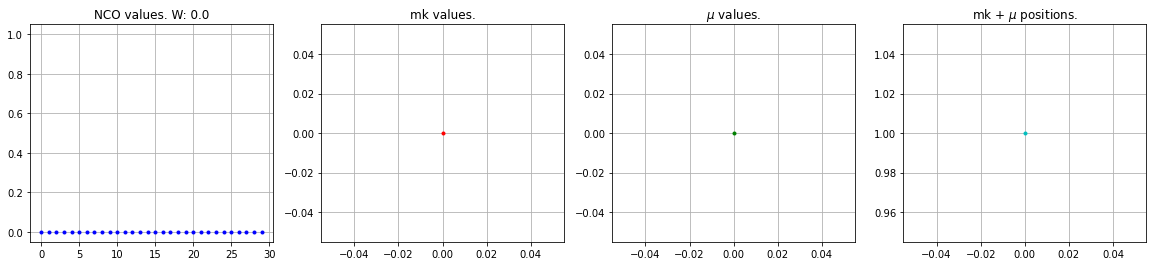

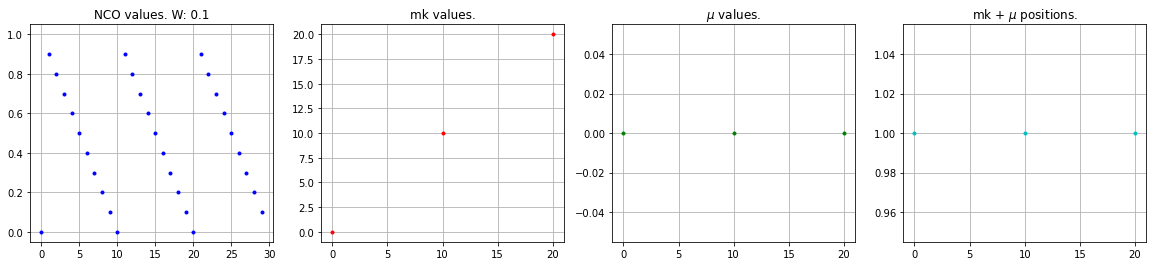

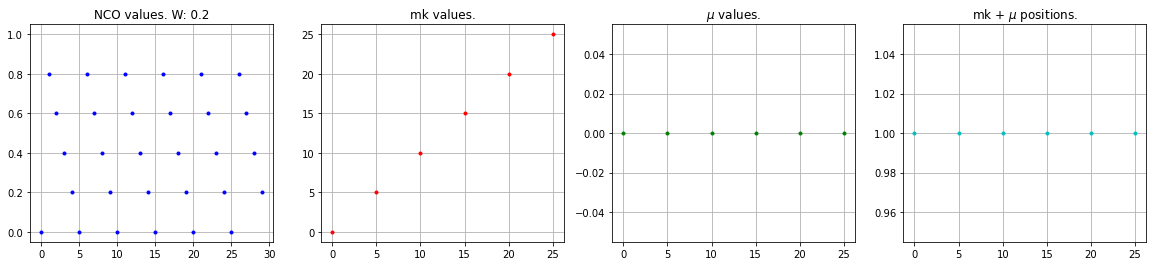

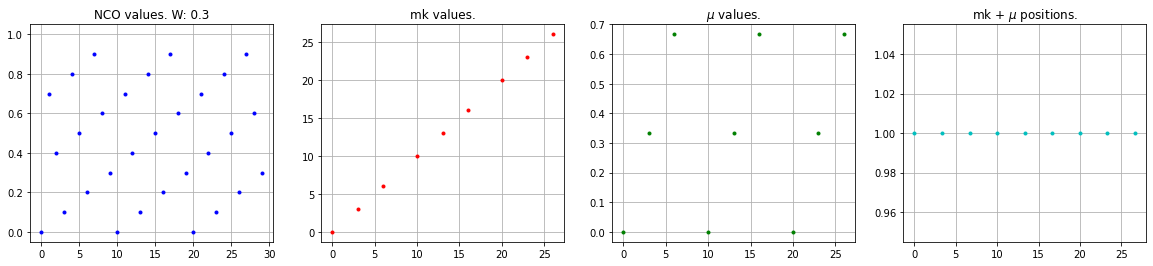

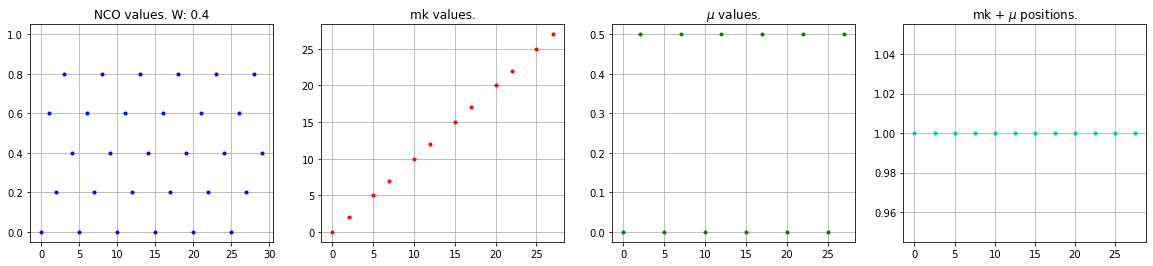

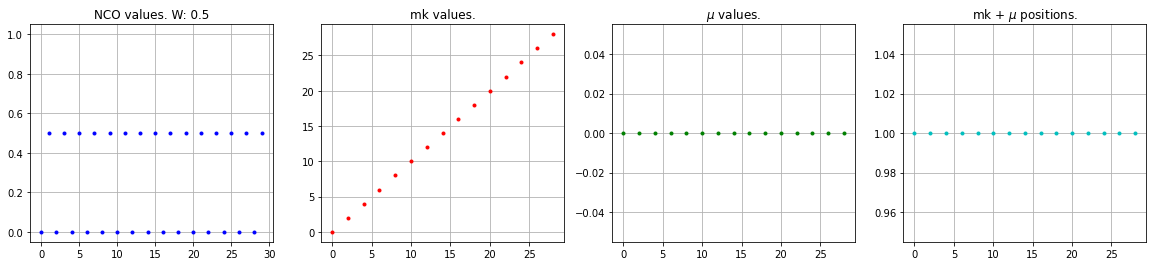

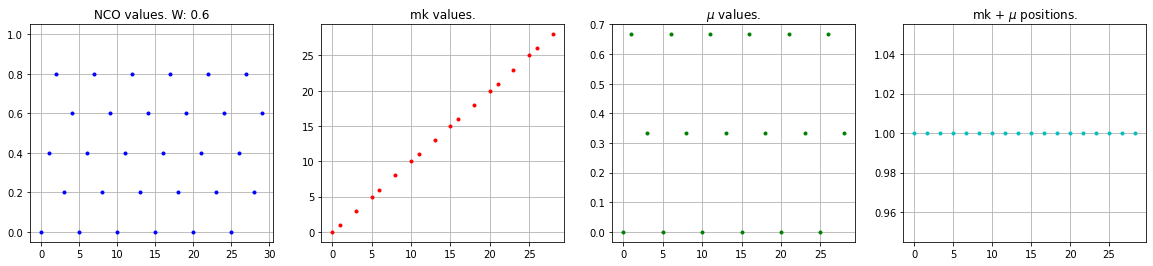

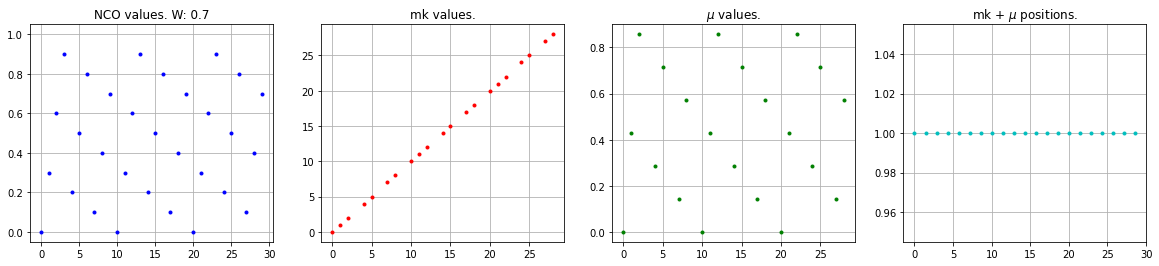

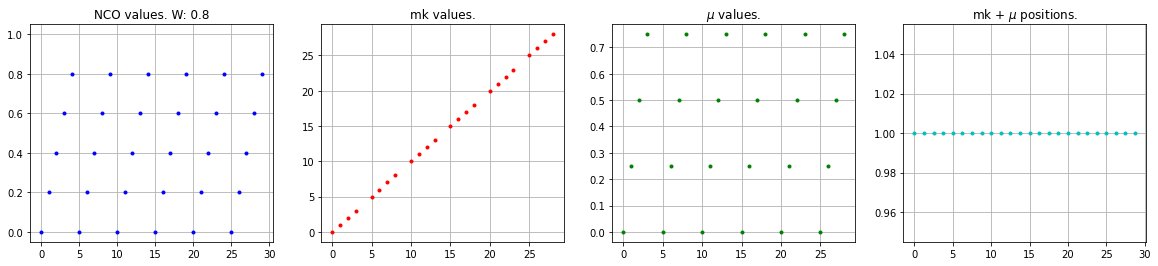

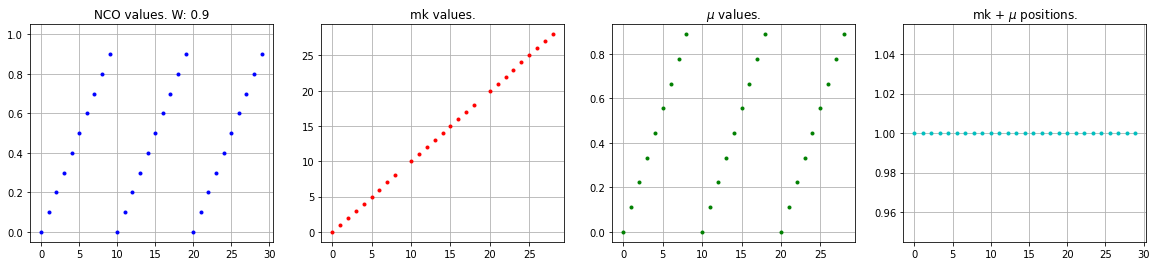

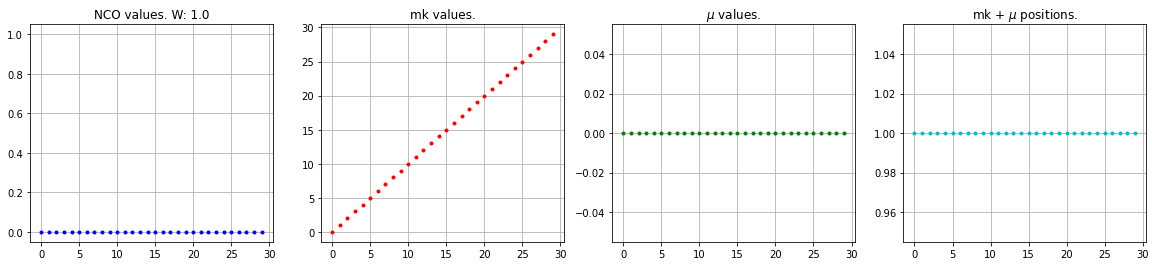

In [ ]:
# Test del NCO # 999

iter_max = 30
fig_num = 0
for iter_W in np.arange(0, 1.1, 0.1):

  vct_nco = np.array([]); vct_mu = np.array([]); vct_mk = np.array([]); 
  NCO = 0; mu = 0; mk = 0;

  for iter in np.arange(iter_max):
    vct_nco = np.append(vct_nco, NCO); vct_mu = np.append(vct_mu, mu); vct_mk = np.append(vct_mk, mk);
    [mk, mu, NCO] = nco(iter_W, NCO, mu, mk, iter) 

  plt.figure(fig_num, figsize=(20, 4))
  plt.subplot(1,4,1)
  plt.title('NCO values. W: {}'.format(np.round(iter_W, 2)))
  plt.plot(np.arange(iter_max), vct_nco, 'b.');
  plt.ylim([-0.05, 1.05])
  plt.grid(True)

  plt.subplot(1,4,2)
  plt.title('mk values.')
  plt.plot(np.arange(iter_max), vct_mk, 'r.');
  plt.grid(True)

  plt.subplot(1,4,3)
  plt.title('$\mu$ values.')
  plt.plot(np.arange(iter_max), vct_mu, 'g.');
  plt.grid(True)

  plt.subplot(1,4,4)
  plt.title('mk + $\mu$ positions.')
  plt.plot(vct_mk + vct_mu, np.ones(iter_max), 'c.');
  plt.grid(True)

  fig_num += 1

Closed loop

Roll-off: 0

same: 1.0091888233912182e-14, transition: -0.7881277378342515


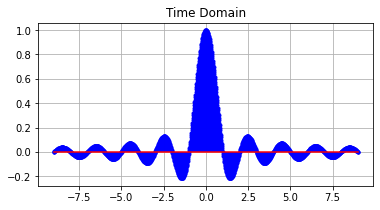

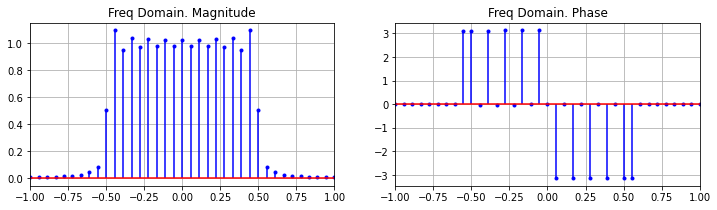

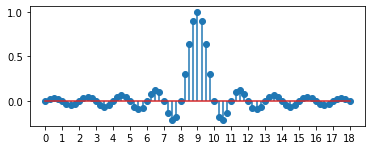

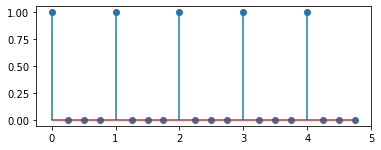

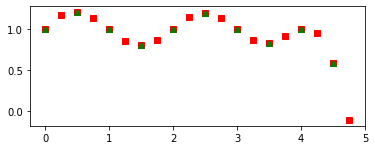

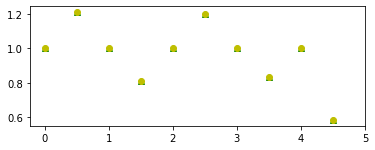

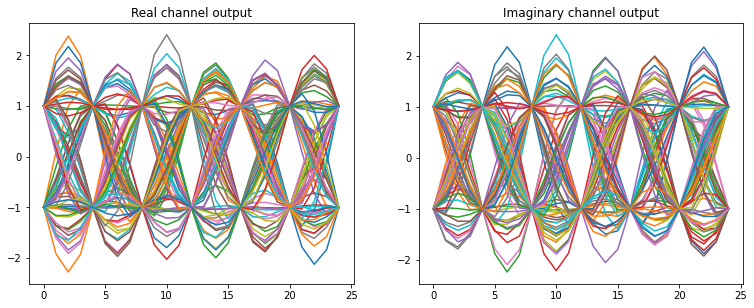

In [ ]:
# Signal received test

_global_fun(alphabet = {'00':-1-1j, '01':-1+1j, '10':1-1j, '11':1+1j}, \
            freq_shift = 0, phase_shift = 0.0, symbols = 2000, ups_value = 4, \
            n = 15, samplesxsym = 64, signal_span = 19, step = 0.001)

vct_bit_source = np.zeros(SYMBOLS//UPS_VALUE*COD_LEN, dtype=np.uintc)
vct_ak = np.zeros(SYMBOLS//UPS_VALUE, dtype=np.complex_)
rcos = channel_raised_cos(BW = 0.5, rolloff = 0, show_fig = [])

[vct_rk, vct_bit_source, vct_h_for_conv, vct_interp, vct_ak] = receive(False, 0, vct_ak, vct_bit_source, rcos, closed_loop = True)

Roll-off: 0.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:519: RuntimeWarning:

invalid value encountered in double_scalars



same: 3.635608197484612e-15, transition: -0.15472997168175728


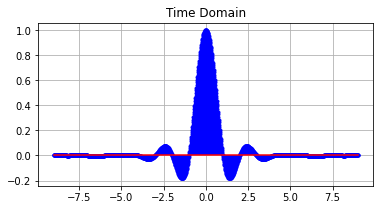

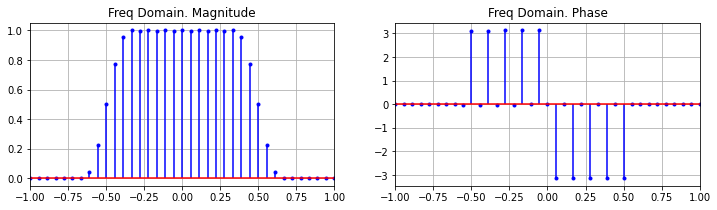

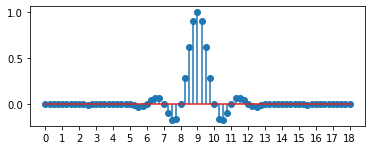

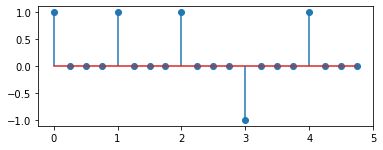

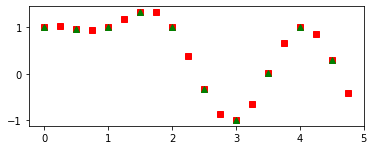

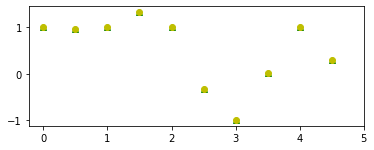

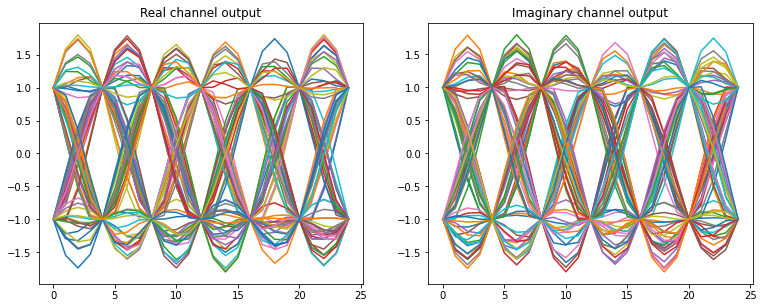

In [ ]:
# Signal received test

_global_fun(alphabet = {'00':-1-1j, '01':-1+1j, '10':1-1j, '11':1+1j}, \
            freq_shift = 0, phase_shift = 0.0, symbols = 2000, ups_value = 4, \
            n = 15, samplesxsym = 64, signal_span = 19, step = 0.001)

vct_bit_source = np.zeros(SYMBOLS//UPS_VALUE*COD_LEN, dtype=np.uintc)
vct_ak = np.zeros(SYMBOLS//UPS_VALUE, dtype=np.complex_)
rcos = channel_raised_cos(BW = 0.5, rolloff = 0.3, show_fig = [])

[vct_rk, vct_bit_source, vct_h_for_conv, vct_interp, vct_ak] = receive(False, 0, vct_ak, vct_bit_source, rcos, closed_loop = True)

Roll-off: 0.7

same: -19.187117216632632, transition: 63.117352287054366


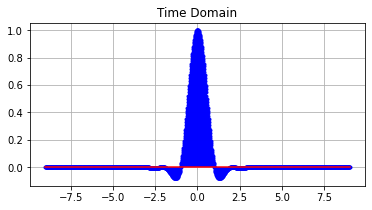

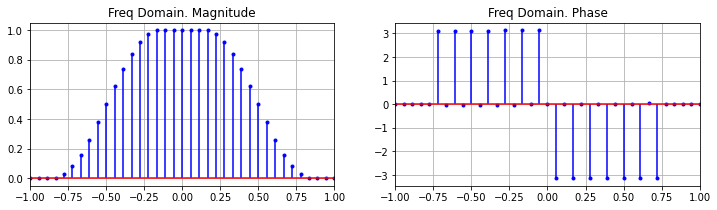

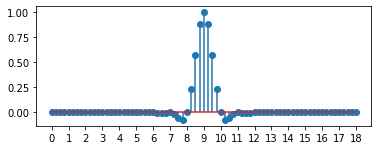

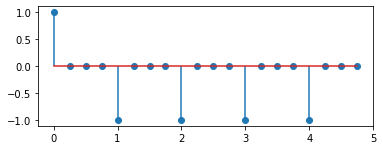

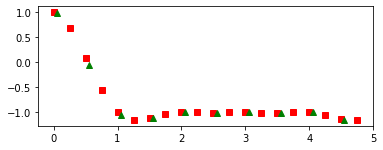

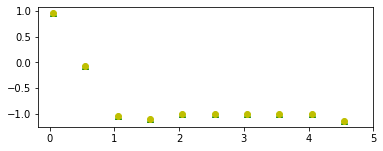

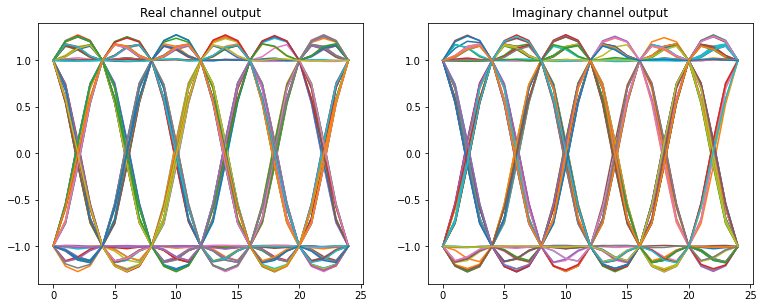

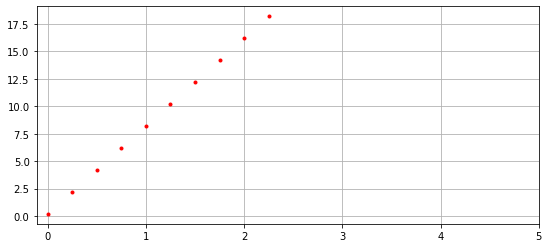

In [ ]:
# Signal received test

_global_fun(alphabet = {'00':-1-1j, '01':-1+1j, '10':1-1j, '11':1+1j}, \
            freq_shift = 0, phase_shift = 0.2, symbols = 2000, ups_value = 4, \
            n = 15, samplesxsym = 64, signal_span = 19, step = 0.001)

vct_bit_source = np.zeros(SYMBOLS//UPS_VALUE*COD_LEN, dtype=np.uintc)
vct_ak = np.zeros(SYMBOLS//UPS_VALUE, dtype=np.complex_)
rcos = channel_raised_cos(BW = 0.5, rolloff = 0.7, show_fig = [])

[vct_rk, vct_bit_source, vct_h_for_conv, vct_interp, vct_ak] = receive(False, 0, vct_ak, vct_bit_source, rcos, closed_loop = True)

Open loop

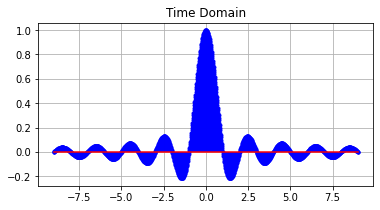

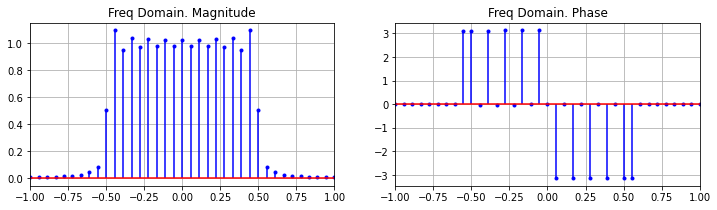

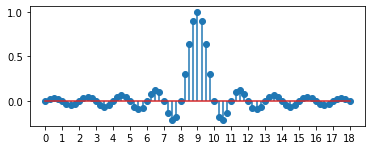

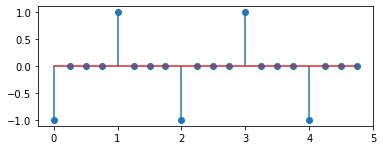

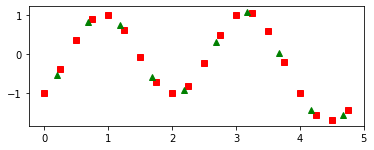

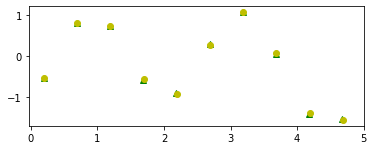

In [ ]:
#@title
# Signal received test

_global_fun(alphabet = {'00':-1-1j, '01':-1+1j, '10':1-1j, '11':1+1j}, \
            freq_shift = 0.01, phase_shift = 0.17, symbols = 2000, ups_value = 4, \
            n = 15, samplesxsym = 64, signal_span = 19, step = 0.001)

vct_bit_source = np.zeros(SYMBOLS//UPS_VALUE*COD_LEN, dtype=np.uintc)
vct_ak = np.zeros(SYMBOLS//UPS_VALUE, dtype=np.complex_)
rcos = channel_raised_cos(BW = 0.5, rolloff = 0, show_fig = [])

[vct_rk, vct_bit_source, vct_h_for_conv, vct_interp, vct_ak] = receive(False, 0, vct_ak, vct_bit_source, rcos, closed_loop = False) 